# Example analysis of Spark metrics collected with sparkMeasure

This is an example analysis of workload metrics collected with sparkMeasure [https://github.com/LucaCanali/sparkMeasure]  
Workload data is produced as described in Example 2 of the blog entry [http://db-blog.web.cern.ch/blog/luca-canali/2017-03-measuring-apache-spark-workload-metrics-performance-troubleshooting]  
The details of how to generate the load and measurements are also reported at the end of this notebook.  
This Jupyter notebook was generated running pyspark/Spark version 2.1.0  
Author: Luca.Canali@cern.ch, March 2017

## Configuration

In [40]:
# This is the file path and name where the metrics are stored
metrics_filename = "<path>/myPerfTaskMetrics1"

# This defines the time window for analysis
# when using metrics coming from taskMetrics.runAndMeasure, 
# get the info from: taskMetrics.beginSnapshot and taskMetrics.endSnapshot
# if you don't have the details, set begin_time and end_time to 0
begin_time = 1490554321913
end_time = 1490554663808

In [41]:
# Initialize libraries used later for plotting

import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline

## Read data from storage and register as Spark temporary view

In [42]:
# Read the metrics from metrics_filename
# it assumes the file is in json format, if a different format is used, update the command
df = spark.read.json(metrics_filename)

In [98]:
# Register data into a temporary view: PerfTaskMetrics
# with some data manipulation: 
#  filter data to limit the time window for analysis 
from pyspark.sql import functions as F

if (end_time == 0):
    end_time = df.agg(F.max(df.finishTime)).collect()[0][0]    
    
if (begin_time == 0):
    begin_time = df.agg(F.min(df.launchTime)).collect()[0][0]    

df.filter("launchTime >= {0} and finishTime <= {1}".format(begin_time, end_time)).createOrReplaceTempView("PerfTaskMetrics")

## Print aggregated metrics

In [99]:
# Prints the aggregated values of the metrics using Pandas to display as HTML table
# this notebook was tested using Anaconda, so among others Pandas are imported by default
# Note that the metrics referring to time measurements are in millisecond

report = spark.sql("""
select count(*) numtasks, max(finishTime) - min(launchTime) as elapsedTime, sum(duration), sum(schedulerDelay),
       sum(executorRunTime), sum(executorCpuTime), sum(executorDeserializeTime), sum(executorDeserializeCpuTime),
       sum(resultSerializationTime), sum(jvmGCTime), sum(shuffleFetchWaitTime), sum(shuffleWriteTime), sum(gettingResultTime),
       max(resultSize), sum(numUpdatedBlockStatuses), sum(diskBytesSpilled), sum(memoryBytesSpilled), 
       max(peakExecutionMemory), sum(recordsRead), sum(bytesRead), sum(recordsWritten), sum(bytesWritten),
       sum(shuffleTotalBytesRead), sum(shuffleTotalBlocksFetched), sum(shuffleLocalBlocksFetched), 
       sum(shuffleRemoteBlocksFetched), sum(shuffleBytesWritten), sum(shuffleRecordsWritten) 
       from PerfTaskMetrics
""").toPandas().transpose()

report.columns=['Metric value']
report

,Metric value
numtasks,312
elapsedTime,341393
sum(duration),10397845
sum(schedulerDelay),3737
sum(executorRunTime),10353312
sum(executorCpuTime),10190371
sum(executorDeserializeTime),40691
sum(executorDeserializeCpuTime),8200
sum(resultSerializationTime),105
sum(jvmGCTime),21524


**Comments**: the report shows that the workload is CPU-bound. The execution time is dominated by workload executing on CPU.  
Finding: the job allocates 56 cores/tasks. However the average amount of CPU used for the duration of the job can be calculated from the metrics as sum(executorcputime) / elapsedtime  = 10190371 / 341393  ~ 30.  
Additional drill down (in the following cells) shows more details of why the average CPU utilization considerably lower than the available CPU? 

## Prepare data to compute number of concurrent running tasks vs. time

In [45]:
# Define the reference time range samples, as equispaced time intervals from begin_time and end_time
# define a temporary view hich will be used in the following SQL
# currently the time interval is hardcoded to 1 sec (= 1000 ms = 10^3 ms)

spark.sql("select id as time, int((id - {0})/1000) as time_normalized from range({0}, {1}, 1000)".
          format(round(begin_time,-3), round(end_time,-3))).createOrReplaceTempView("TimeRange")


In [46]:
# For each reference time value taken from TimeRange, list the number of running tasks
# the output is a temporary view ConcurrentRunningTasks

spark.sql("""
select TimeRange.time_normalized as time, PTM.*
from TimeRange left outer join PerfTaskMetrics PTM 
where TimeRange.time between PTM.launchTime and PTM.finishTime
order by TimeRange.time_normalized
""").createOrReplaceTempView("ConcurrentRunningTasks")

## Plot number of concurrent running tasks vs. time

In [47]:
plot_num_running_tasks = spark.sql("""
select time, count(*) num_running_tasks 
from ConcurrentRunningTasks 
group by time
order by time
""").toPandas()

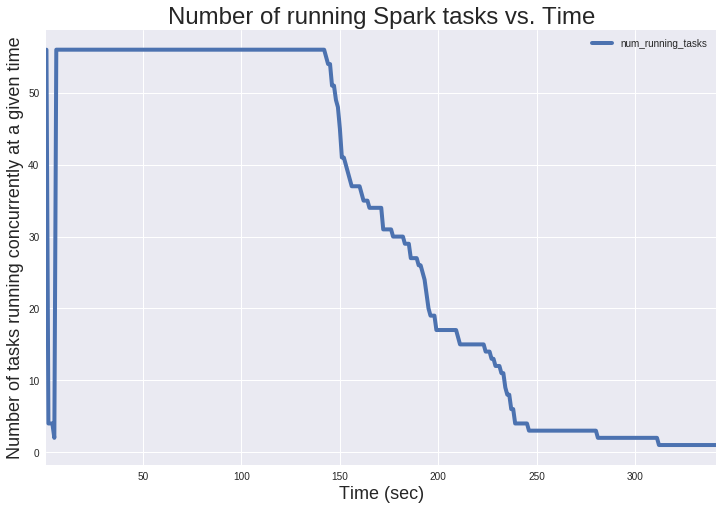

In [77]:
ax = plot_num_running_tasks.plot(x='time', y='num_running_tasks', linestyle='solid', linewidth=4, figsize=(12, 8))
ax.set_title("Number of running Spark tasks vs. Time", fontsize=24)
ax.set_xlabel("Time (sec)", fontsize=18)
ax.set_ylabel("Number of tasks running concurrently at a given time", fontsize=18)

plt.savefig("/home/luca/Spark/test/blog_image_orig.png")

**Comments:** the graph of the number of active tasks as funciton of time shows that the execution has a long tail and stragglers where the CPU utilization is slow. For the first 150 seconds of the execution all available CPU is used (56 cores) then a slow ramp down phase is seen, finally ending in a "long tail" with stragglers.

## Heatmap of number of concurrent tasks as function of host name and time

In [49]:
# load into Pandas the values of number of concurrent running tasks per host and time sample
# see also the heatmap visualization in the next cell

plot_heatmap_running_tasks_per_host = spark.sql("""
select time, host, count(*) num_running_tasks 
from ConcurrentRunningTasks 
group by time, host
order by time, host
""").toPandas()

pivoted_heatmapPandas = plot_heatmap_running_tasks_per_host.pivot(index='time', columns='host', values='num_running_tasks')

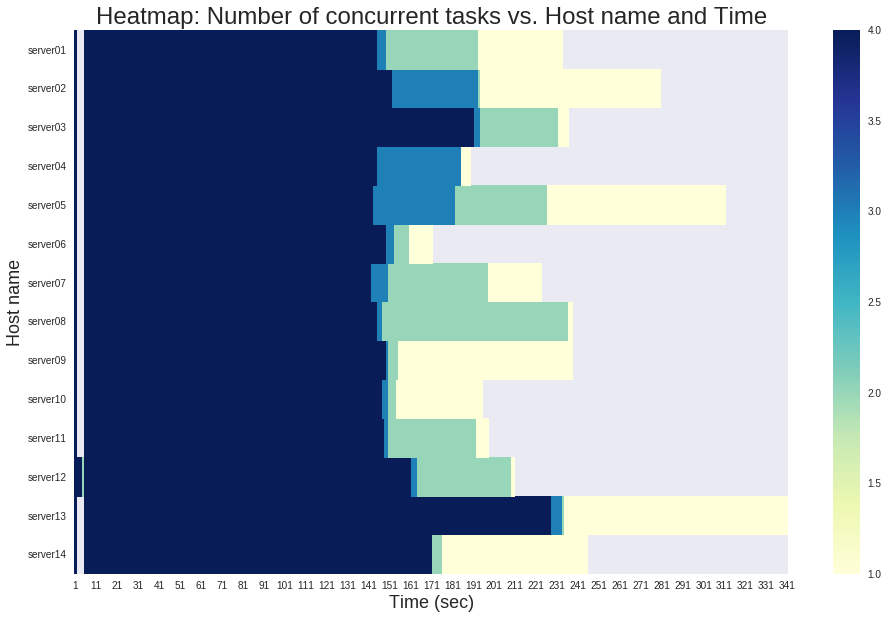

In [73]:
# plot heatmap
plt.figure(figsize=(16, 10))
ax = sns.heatmap(pivoted_heatmapPandas.T, cmap="YlGnBu", xticklabels=10)

ax.set_title("Heatmap: Number of concurrent tasks vs. Host name and Time", fontsize=24)
ax.set_xlabel("Time (sec)", fontsize=18)
ax.set_ylabel("Host name", fontsize=18)
ax.set_
plt.show()


**Comment:** The heatmap shows that the execution suffers from a small number of stragglers. In particualr server13 is the last one to finish, seconds last is server05.

## Investigate task duration by host.

In [51]:
spark.sql("""
select host, min(duration), round(avg(duration),0), max(duration), sum(duration), count(*) num_tasks 
from PerfTaskMetrics 
group by host
order by 3 desc
""").show()

+--------+-------------+-----------------------+-------------+-------------+---------+
|    host|min(duration)|round(avg(duration), 0)|max(duration)|sum(duration)|num_tasks|
+--------+-------------+-----------------------+-------------+-------------+---------+
|server13|           96|                84928.0|       335830|      1019141|       12|
|server14|           76|                62090.0|       239613|       745080|       12|
|server12|           22|                43621.0|       204657|       741551|       17|
|server03|           24|                37853.0|       132663|       832771|       22|
|server10|           23|                36893.0|       148091|       627180|       17|
|server02|           24|                36397.0|       176056|       800735|       22|
|server06|          287|                36139.0|       147219|       614359|       17|
|server11|           28|                35240.0|        97927|       669562|       19|
|server01|           23|                334

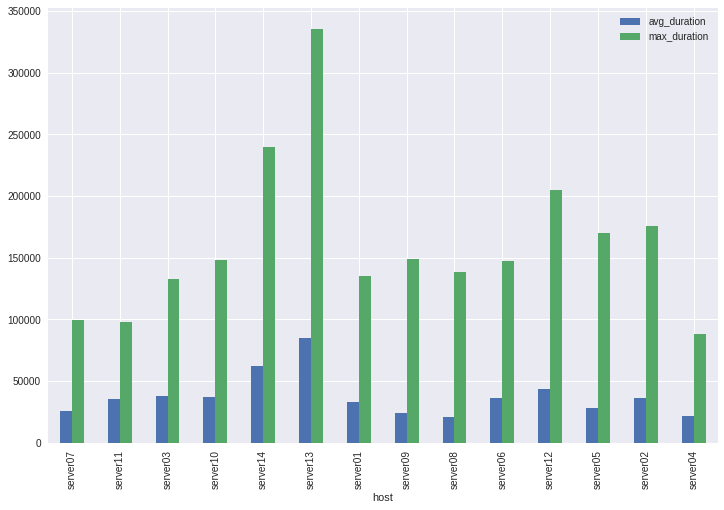

In [52]:
spark.sql("""
select host, avg(duration) avg_duration, max(duration) max_duration
from PerfTaskMetrics 
group by host""").toPandas().plot(x='host', kind='bar', figsize=(12, 8))

**Comment:** server13 and server14 are the slowest on average to execute the tasks for this workload. Additional investigations not reported here, reveal that server13 and server14 are of lower specs than the rest of the servers in the cluster.

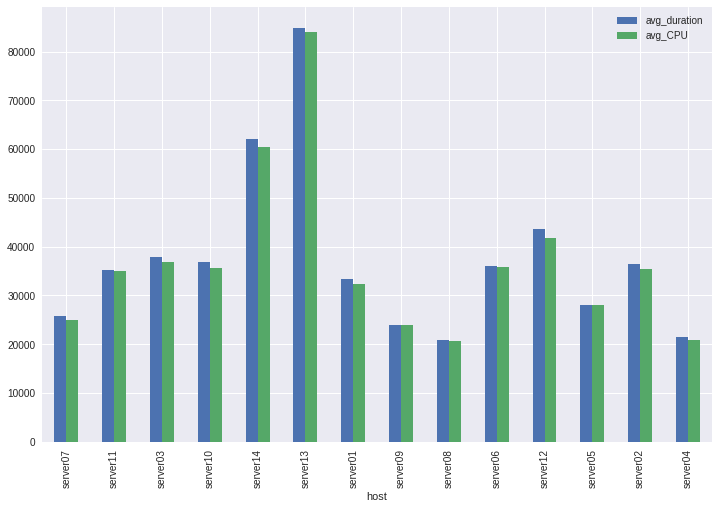

In [53]:
spark.sql("""
select host, avg(duration) avg_duration, avg(executorCpuTime) avg_CPU
from PerfTaskMetrics 
group by host""").toPandas().plot(x='host', kind='bar', figsize=(12, 8))

**Comment:** This graphs reiterates the point that the workload is fully CPU bound.

## As a reference, this are the metrics avaliable. Continue your exploration from here!

In [54]:
spark.sql("desc PerfTaskMetrics").show(50,False)

+--------------------------+---------+-------+
|col_name                  |data_type|comment|
+--------------------------+---------+-------+
|bytesRead                 |bigint   |null   |
|bytesWritten              |bigint   |null   |
|diskBytesSpilled          |bigint   |null   |
|duration                  |bigint   |null   |
|executorCpuTime           |bigint   |null   |
|executorDeserializeCpuTime|bigint   |null   |
|executorDeserializeTime   |bigint   |null   |
|executorId                |string   |null   |
|executorRunTime           |bigint   |null   |
|finishTime                |bigint   |null   |
|gettingResultTime         |bigint   |null   |
|host                      |string   |null   |
|index                     |bigint   |null   |
|jobId                     |bigint   |null   |
|jvmGCTime                 |bigint   |null   |
|launchTime                |bigint   |null   |
|memoryBytesSpilled        |bigint   |null   |
|numUpdatedBlockStatuses   |bigint   |null   |
|peakExecutio

## Details on the workload and collecting the metrics using sparkMeasure

Metrics investigations in this notebook originate from a data saved from DataFrame using "sparkMeasure.TaskMetrics" as in this example:  
<code>
val df = taskMetrics.createTaskMetricsDF()
taskMetrics.saveData(df, "myPerfTaskMetrics1")
</code>

---
The workload investigated here was generated with:

<code>spark-shell --num-executors 14 --executor-cores 4 --driver-memory 2g  --executor-memory 2g --jars sparkMeasure/target/scala-2.11/spark-measure_2.11-0.1-SNAPSHOT.jar

val testNumRows = 1e7.toLong
sql(s"select id from range($testNumRows)").createOrReplaceTempView("t0")
sql("select id, floor(200*rand()) bucket, floor(1000*rand()) val1, floor(10*rand()) val2 from t0").cache().createOrReplaceTempView("t1")
sql("select count(*) from t1").show
</code>

This part instantiates the classe used to measure Task metrics using custom listeners:  
<code>val taskMetrics = new ch.cern.sparkmeasure.TaskMetrics(spark)</code>

This is the code to run the test workload:
<code>
taskMetrics.runAndMeasure(sql(
"select a.bucket, sum(a.val2) tot from t1 a, t1 b where a.bucket=b.bucket and a.val1+b.val1<1000 group by a.bucket order by a.bucket").show)
</code>
